In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.layers.core import Dense, Activation, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report
import scipy

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
model_dir = 'trained_models/'
dir_ = 'HASYv2/'
K.set_image_data_format('channels_first')

# LABELS

In [4]:
def read_csv(path):
    return pd.read_csv(dir_ + path)

In [5]:
whole_dataset = read_csv('hasy-data-labels.csv')
print(whole_dataset.head())
print(whole_dataset.info())

                     path  symbol_id latex  user_id
0  hasy-data/v2-00000.png         31     A       50
1  hasy-data/v2-00001.png         31     A       10
2  hasy-data/v2-00002.png         31     A       43
3  hasy-data/v2-00003.png         31     A       43
4  hasy-data/v2-00004.png         31     A     4435
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168233 entries, 0 to 168232
Data columns (total 4 columns):
path         168233 non-null object
symbol_id    168233 non-null int64
latex        168233 non-null object
user_id      168233 non-null int64
dtypes: int64(2), object(2)
memory usage: 5.1+ MB
None


In [6]:
# Read symbols for all classification classes
symbols = read_csv('symbols.csv')
print(symbols.head())
print(symbols.info())

   symbol_id latex  training_samples  test_samples
0         31     A               137            22
1         32     B                53             8
2         33     C               120            14
3         34     D                50             8
4         35     E                48             6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 4 columns):
symbol_id           369 non-null int64
latex               369 non-null object
training_samples    369 non-null int64
test_samples        369 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.6+ KB
None


# IMAGE PREPROCESSING

In [7]:
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency 
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL 
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

def preprocess_img(path):
    # Open Image
    im = Image.open(dir_ + path)
    
    # Resize image to 32 by 32
    if im.size != (32,32):
        im = im.resize((32,32))
        
    # Convert image to a single greyscale channel
    im = remove_transparency(im).convert('L')
    
    # Convert image to numpy array
    I = np.asarray(im)
    
    #Close image
    im.close()
    
    return I

### Create Dataset as x and y

In [8]:
def populate_images(dataset):
    temp = []
    for i in range(len(dataset)):
        path = dataset.iloc[i]['path']
        pathsplit = path.split('/')
        if len(pathsplit) > 2:
            path = '/'.join([pathsplit[-2],pathsplit[-1]])
        img = preprocess_img(path)
        temp.append(img)
    dataset['img'] = [i for i in temp]
    return dataset

def convert_to_one_hot_encode(data, no_categories):
    data = np.array(data).reshape(-1)
    print('len of dataset', len(data))
    return np.eye(no_categories)[data]

# to process output to the value
# returns a list with all the categories with more than 50% accuracy
def one_hot_encode_to_char(arr, threshold=0.5, get_max=True):
    result = []
    val = 0
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((val, arr[i]))
        val +=1
    _max = []
    high = 0
    if get_max:
        for i in result:
            if i[1] > high:
                _max = [i[0]]
                high = i[1]
        return _max
    else:
        return [i[0] for i in result]

In [9]:
# whole_dataset = populate_images(whole_dataset)

#### Reset Symbol names to start from 0 to 368

In [10]:
# change name of previous symbol
symbols['old_symbol'] = symbols['symbol_id']
symbols = symbols.drop('symbol_id', axis=1)

# add new id according to index of character
symbols['new_id'] = symbols.index

# make a symbols dict that references each symbol_id to the new symbol
symbols_dict = {}
for i in range(len(symbols)):
    symbols_dict[symbols['old_symbol'][i]] = symbols['new_id'][i]

In [11]:
whole_dataset['symbol_id'] = [symbols_dict[i] for i in whole_dataset['symbol_id']]

### Stratified Train Test Split

In [12]:
def get_df_split(ds, stratify_col, test_size=0.2):
    _train, _test = train_test_split(ds, test_size=test_size, stratify=ds[stratify_col])
    return _train, _test

In [13]:
# use this cell only once, then load the saved csvs for train and test splits for recreation
# train, test = get_df_split(whole_dataset, stratify_col='symbol_id', test_size=0.1)
# train = train.reset_index(drop=True)
# test = test.reset_index(drop=True)
# train.to_csv(dir_+'train.csv')
# test.to_csv(dir_+'test.csv')

In [14]:
# Use this cell to load csvs
train = read_csv('train.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
test = read_csv('test.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)

In [15]:
train.head()

,path,symbol_id,latex,user_id
0,hasy-data/v2-15966.png,331,\mathds{R},16925
1,hasy-data/v2-152185.png,312,\mathcal{O},16925
2,hasy-data/v2-71601.png,125,\%,16925
3,hasy-data/v2-50153.png,93,\varphi,124916
4,hasy-data/v2-32919.png,68,\gamma,16925


In [16]:
symbols_list = np.array(whole_dataset['symbol_id']).reshape(-1)

In [17]:
def get_label_count_df(df_train, df_test, sym_list=symbols_list):
    train_labels_count = {}
    test_labels_count = {}
    perc_labels_count = {}
    for i in sym_list:
        train_labels_count[i] = 0
        test_labels_count[i] = 0
    for i in range(len(df_train)):
        train_labels_count[df_train.loc[i,'symbol_id']] += 1
    for i in range(len(df_test)):
        test_labels_count[df_test.loc[i,'symbol_id']] += 1
    for i in sym_list:
        perc = (train_labels_count[i] / (train_labels_count[i] + test_labels_count[i])) * 100
        perc_labels_count[i] = (train_labels_count[i], test_labels_count[i], round(perc,2))
    return perc_labels_count

In [20]:
labels_count = get_label_count_df(train, test, symbols_list)
print(labels_count)

{0: (143, 16, 89.94), 1: (55, 6, 90.16), 2: (121, 13, 90.3), 3: (52, 6, 89.66), 4: (49, 5, 90.74), 5: (50, 6, 89.29), 6: (106, 12, 89.83), 7: (58, 6, 90.62), 8: (90, 10, 90.0), 9: (94, 10, 90.38), 10: (86, 10, 89.58), 11: (100, 11, 90.09), 12: (108, 12, 90.0), 13: (95, 10, 90.48), 14: (76, 8, 90.48), 15: (65, 7, 90.28), 16: (60, 7, 89.55), 17: (75, 8, 90.36), 18: (57, 6, 90.48), 19: (50, 6, 89.29), 20: (53, 6, 89.83), 21: (50, 6, 89.29), 22: (56, 6, 90.32), 23: (49, 5, 90.74), 24: (50, 6, 89.29), 25: (59, 6, 90.77), 26: (959, 107, 89.96), 27: (120, 13, 90.23), 28: (106, 12, 89.83), 29: (112, 12, 90.32), 30: (108, 12, 90.0), 31: (55, 6, 90.16), 32: (70, 8, 89.74), 33: (90, 10, 90.0), 34: (68, 7, 90.67), 35: (109, 12, 90.08), 36: (81, 9, 90.0), 37: (1380, 153, 90.02), 38: (2341, 260, 90.0), 39: (1018, 113, 90.01), 40: (3060, 340, 90.0), 41: (1011, 112, 90.03), 42: (77, 9, 89.53), 43: (51, 6, 89.47), 44: (60, 7, 89.55), 45: (52, 6, 89.66), 46: (57, 6, 90.48), 47: (59, 7, 89.39), 48: (50, 

#### One Hot Encode labels

In [18]:
no_categories = 369
train_one_hot_symbols = convert_to_one_hot_encode(train['symbol_id'], no_categories)
test_one_hot_symbols = convert_to_one_hot_encode(test['symbol_id'], no_categories)

len of dataset 151409
len of dataset 16824


In [19]:
# whole_dataset['symbol_id_ohe'] = [list(one_hot_symbols[i]) for i in range(len(whole_dataset))]
train['symbol_id_ohe'] = [list(train_one_hot_symbols[i]) for i in range(len(train))]
test['symbol_id_ohe'] = [list(test_one_hot_symbols[i]) for i in range(len(test))]

In [20]:
train = populate_images(train)
test = populate_images(test)

In [21]:
train.head()

,path,symbol_id,latex,user_id,symbol_id_ohe,img
0,hasy-data/v2-15966.png,331,\mathds{R},16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,hasy-data/v2-152185.png,312,\mathcal{O},16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,hasy-data/v2-71601.png,125,\%,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,hasy-data/v2-50153.png,93,\varphi,124916,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,hasy-data/v2-32919.png,68,\gamma,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [22]:
test.head()

,path,symbol_id,latex,user_id,symbol_id_ohe,img
0,hasy-data/v2-91515.png,171,\approx,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,hasy-data/v2-33217.png,68,\gamma,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 0, 0, 255, 255, 255..."
2,hasy-data/v2-31253.png,67,\Sigma,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,hasy-data/v2-113978.png,224,\uparrow,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,hasy-data/v2-36827.png,72,\zeta,16925,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


# CONVOLUTIONAL NEURAL NETWORKS

In [23]:
# if channels location is changed , update get_input_shape()
# def get_input_shape(dataset):
#    return (len(dataset),1,32,32)
#    return (1,32,32)

In [24]:
# Hyperparameters
smooth = 1

# define the channels location
data_format = 'channels_first'

# number of classification labels/classes
classes = 369

# input shape of dataset
# input_shape = get_input_shape(data_train[0])
# input_shape = get_input_shape(whole_dataset)
input_shape = (1, 32, 32)
print(input_shape)

# optimizer
lr = 0.001
optimizer = SGD(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 200

(1, 32, 32)


# NN 1
# adapted from large layer
def get_layers(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

In [25]:
# NN 1
# adapted from large layer
def get_layers(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

# create network
model = create_network(input_shape, data_format, classes)
# compile network
model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

# NN 2
def create_conv_layer(f,stride,activationfn,padding,prevlayer,dropout):

    conv = Conv2D(f,stride,activation=activationfn,padding=padding)(prevlayer)
    conv = Dropout(dropout)(conv)
    conv = Conv2D(f,stride,activation=activationfn,padding=padding)(conv)

    return conv

def maxpooling_fn(prevlayer):

    return MaxPooling2D(pool_size=(2,2), padding='same')(prevlayer)

def concatenate_fn(f,kernal,stride,padding,src,dest):

    return concatenate([Conv2DTranspose(f,kernal,strides=stride,padding=padding)(src),dest],axis=3)

def dice_coef(y_true,y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true,y_pred):

    return -dice_coef(y_true,y_pred)

def getnetwork():

    inputs = keras.engine.input_layer.Input((1,img_row,img_col))

    conv1 = create_conv_layer(32,(3,3),'relu','same',inputs,0.2)
    pool1 = maxpooling_fn(conv1)

    conv2 = create_conv_layer(64,(3,3),'relu','same',pool1,0.2)
    pool2 = maxpooling_fn(conv2)


    conv3 = create_conv_layer(128,(3,3),'relu','same',pool2,0.3)
    pool3 = maxpooling_fn(conv3)

    conv4 = create_conv_layer(256,(3,3),'relu','same',pool3,0.3)
    pool4 = maxpooling_fn(conv4)

    conv5 = create_conv_layer(512,(3,3),'relu','same',pool4,0.3)
    pool5 = maxpooling_fn(conv5)

    up6 = concatenate_fn(256,(2,2),(2,2),'same',conv5,conv4)
    conv6 = create_conv_layer(256,(3,3),'relu','same',up6,0.3)

    up7 = concatenate_fn(128,(2,2),(2,2),'same',conv6,conv3)
    conv7 = create_conv_layer(128,(3,3),'relu','same',up7,0.3)

    up8 = concatenate_fn(64,(2,2),(2,2),'same',conv7,conv2)
    conv8 = create_conv_layer(64,(3,3),'relu','same',up8,0.3)

    up9 = concatenate_fn(32,(2,2),(2,2),'same',conv8,conv1)
    conv9 = create_conv_layer(32,(3,3),'relu','same',up9,0.3)


    conv10 = Conv2D(1,(1,1),activation='sigmoid')(conv9)

    model = Model(inputs=[inputs],outputs=[conv10])

    # model.compile(optimizer=Adam(lr=0.00001),loss=dice_coef_loss,metrics=[dice_coef])
    model.compile(optimizer=SGD(lr=0.01),loss=dice_coef_loss,metrics=[dice_coef])

    return model

img_row = 32
img_col = 32
model = getnetwork()

## Model fit on whole dataset

In [15]:
def gen_x_y(dataset, input_shape):
    x = np.array(list(dataset['img']))
    y = np.array(list(dataset['symbol_id_ohe']))
    x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
    
    # Normalize data to 0-1
    x = x.astype("float32") / 255.0
    
    #x = np.array(list(dataset['img']))
    #y = np.array(list(dataset['symbol_id']))
    return x,y

def set_gpu_memory_target(frac):
    """Configure Tensorflow to use a fraction of available GPU memory.

    Use this for evaluating models in parallel. By default, Tensorflow
    will try to map all available GPU memory in advance. You can
    configure to use just a fraction so that multiple processes can run
    in parallel. For example, if you want to use 2 works, set the
    memory fraction to 0.5.

    If you are using Python multiprocessing, you must call this function
    from the *worker* process (not from the parent).

    This function does nothing if Keras is using a backend other than
    Tensorflow.
    """
    if keras.backend.backend() != 'tensorflow':
        return
    # Do the import here, not at the top, in case Tensorflow is not
    # installed at all.
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = frac
    #config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


In [16]:
# data
x,y = gen_x_y(whole_dataset, input_shape)

In [19]:
#set_gpu_memory_target(0.9)
#with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#K.clear_session()
# train network
#tf.reset_default_graph()
model.fit(x,y, batch_size=batch_size, epochs=epochs, verbose=1)
model.save(dir_+'hasyv2model.h5')

Epoch 1/100
168233/168233 [==============================] - 32s 189us/step - loss: 4.2094 - acc: 0.225715s - loss: 5.1555 - acc:  - ETA: 15s - loss: 5.14 - ETA: 10s - loss: 4.8532 - acc:  - ETA: 9s - loss: 4. - ETA:  - ETA: 6s - loss: 4.6004 - acc: 0 - ETA: 5s - loss: 4.5766 - acc: 0 - ETA: 5s - - ETA: 3s - loss: 4.4380 - acc: 0 - ETA: 3s - loss: 4.4165 - acc: - ETA: 0s - loss: 4.2232 - acc: 0
Epoch 2/100
168233/168233 [==============================] - 30s 178us/step - loss: 1.8313 - acc: 0.5821: 6s - - ETA: 4s - loss: 1.8783 - acc: 0.57 - ETA: 4s - loss: 1.8769 - ac - ETA: 4s - loss: 1.8712 - acc:  - ETA: 3s - loss:  - ETA: 2s - loss: 1.8570  - ETA: 1s - loss: 1.8473 - acc: 0.5 - ETA: 1s - loss: 1.8461 -  - ETA: 0s - loss: 1.840 - ETA: 0s - loss: 1.8314 - acc: 0.582
Epoch 3/100
168233/168233 [==============================] - 30s 178us/step - loss: 1.3733 - acc: 0.668224s - loss: 1.46 - ETA: 24s -  - - ETA: 22s - loss: 1. - ETA: 21s - loss: 1.4483 - acc:  - ETA: 21s - loss: 1.4447 -

In [35]:
print(model.summary())
#plot_model(model, to_file=dir_+'model.png')

NameError: name 'model' is not defined

### Metrics

In [52]:
# to load model use
model = load_model(dir_+'hasyv2model.h5')

In [53]:
res = model.predict(x)

In [56]:
# convert predictions from one hot encoded to label value
y_pred = []
for i in range(len(res)):
    # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
    val = one_hot_encode_to_char(res[i], threshold = 0.1, get_max=True)
    if len(val) > 0:
        y_pred.append(val[0])
    else:
        y_pred.append(None)
        print(":(")

In [57]:
# convert test values from one hot encoded to label value
y_true = []
for i in range(len(y)):
    # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
    val = one_hot_encode_to_char(y[i], threshold = 0.9, get_max=True)
    if len(val) > 0:
        y_true.append(val[0])
    else:
        y_true.append(None)
        print(":(")

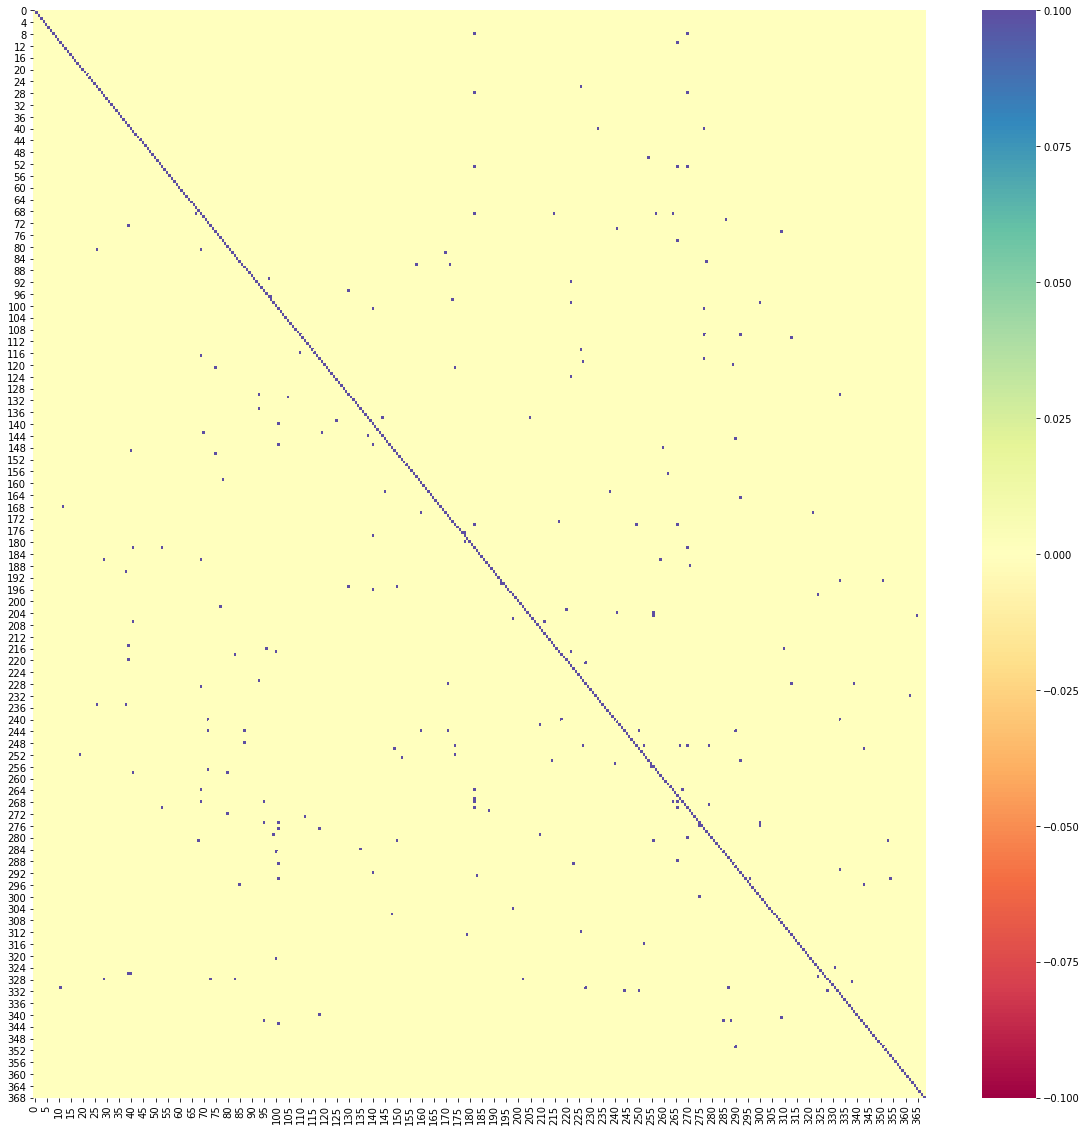

In [59]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs1 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs1, cmap="Spectral", robust=True)

In [60]:
cr1 = classification_report(y_true, y_pred, digits=4)
print(cr1)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       159
           1     1.0000    1.0000    1.0000        61
           2     1.0000    1.0000    1.0000       134
           3     1.0000    1.0000    1.0000        58
           4     1.0000    1.0000    1.0000        54
           5     1.0000    1.0000    1.0000        56
           6     1.0000    1.0000    1.0000       118
           7     1.0000    1.0000    1.0000        64
           8     1.0000    0.8600    0.9247       100
           9     1.0000    1.0000    1.0000       104
          10     1.0000    1.0000    1.0000        96
          11     0.9906    0.9459    0.9677       111
          12     0.9917    1.0000    0.9959       120
          13     1.0000    1.0000    1.0000       105
          14     1.0000    1.0000    1.0000        84
          15     1.0000    1.0000    1.0000        72
          16     1.0000    1.0000    1.0000        67
          17     1.0000    

## Model with Random Train Test Split Dataset

In [62]:
def gen_x_y_train_test(dataset, input_shape, test_size=0.2):
    x = np.array(list(dataset['img']))
    y = np.array(list(dataset['symbol_id_ohe']))
    x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    x = x.astype("float32") / 255.0
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [73]:
X_train, X_test, y_train, y_test = gen_x_y_train_test(whole_dataset, input_shape, test_size=0.2)

In [27]:
# to count number of records in test set for each label
labels_count = {}
for i in symbols_list:
    labels_count[i] = 0
for i in range(len(y_train)):
    j = one_hot_encode_to_char(y_train[i])[0]
    labels_count[j] += 1
print(labels_count)

{0: 130,
 1: 51,
 2: 104,
 3: 47,
 4: 44,
 5: 42,
 6: 91,
 7: 48,
 8: 80,
 9: 86,
 10: 80,
 11: 85,
 12: 92,
 13: 94,
 14: 68,
 15: 56,
 16: 53,
 17: 66,
 18: 47,
 19: 45,
 20: 50,
 21: 48,
 22: 51,
 23: 41,
 24: 49,
 25: 57,
 26: 852,
 27: 109,
 28: 90,
 29: 95,
 30: 101,
 31: 53,
 32: 62,
 33: 83,
 34: 66,
 35: 102,
 36: 73,
 37: 1236,
 38: 2106,
 39: 896,
 40: 2690,
 41: 907,
 42: 69,
 43: 48,
 44: 55,
 45: 47,
 46: 53,
 47: 53,
 48: 46,
 49: 49,
 50: 55,
 51: 44,
 52: 48,
 53: 48,
 54: 44,
 55: 52,
 56: 50,
 57: 41,
 58: 58,
 59: 51,
 60: 51,
 61: 42,
 62: 50,
 63: 44,
 64: 54,
 65: 46,
 66: 53,
 67: 1482,
 68: 920,
 69: 496,
 70: 998,
 71: 823,
 72: 683,
 73: 545,
 74: 530,
 75: 383,
 76: 428,
 77: 590,
 78: 116,
 79: 200,
 80: 118,
 81: 806,
 82: 352,
 83: 935,
 84: 322,
 85: 2046,
 86: 314,
 87: 644,
 88: 565,
 89: 178,
 90: 351,
 91: 536,
 92: 490,
 93: 1210,
 94: 725,
 95: 455,
 96: 354,
 97: 512,
 98: 637,
 99: 1929,
 100: 2829,
 101: 602,
 102: 844,
 103: 714,
 104: 89,
 105

In [ ]:
# create network
model = create_network(input_shape, data_format, classes)
# compile network
model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

In [42]:
model.fit(X_train, y_train, validation_data =(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1)
model.save(dir_+'hasyv2model2.h5')

Train on 134586 samples, validate on 33647 samples
Epoch 1/100
134586/134586 [==============================] - 27s 197us/step - loss: 4.6600 - acc: 0.1535 - val_loss: 3.5009 - val_acc: 0.2937
Epoch 2/100
134586/134586 [==============================] - 25s 187us/step - loss: 2.5106 - acc: 0.4695 - val_loss: 2.2849 - val_acc: 0.4841
Epoch 3/100
134586/134586 [==============================] - 26s 194us/step - loss: 1.7683 - acc: 0.5922 - val_loss: 1.7380 - val_acc: 0.5825
Epoch 4/100
134586/134586 [==============================] - 26s 192us/step - loss: 1.4003 - acc: 0.6616 - val_loss: 1.4592 - val_acc: 0.6479
Epoch 5/100
134586/134586 [==============================] - 25s 189us/step - loss: 1.1737 - acc: 0.7051 - val_loss: 1.2589 - val_acc: 0.6769
Epoch 6/100
134586/134586 [==============================] - 25s 187us/step - loss: 1.0170 - acc: 0.7368 - val_loss: 1.1377 - val_acc: 0.7069
Epoch 7/100
134586/134586 [==============================] - 25s 187us/step - loss: 0.8952 - acc:

### Metrics

In [74]:
# to load model use
model = load_model(dir_+'hasyv2model2.h5')

In [76]:
res = model.predict(X_test)

In [77]:
# convert predictions from one hot encoded to label value
y_pred = []
for i in range(len(res)):
    # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
    val = one_hot_encode_to_char(res[i], threshold = 0.1, get_max=True)
    if len(val) > 0:
        y_pred.append(val[0])
    else:
        y_pred.append(None)
        print(":(")

In [78]:
# convert test values from one hot encoded to label value
y_true = []
for i in range(len(y_test)):
    # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
    val = one_hot_encode_to_char(y_test[i], threshold = 0.9, get_max=True)
    if len(val) > 0:
        y_true.append(val[0])
    else:
        y_true.append(None)
        print(":(")

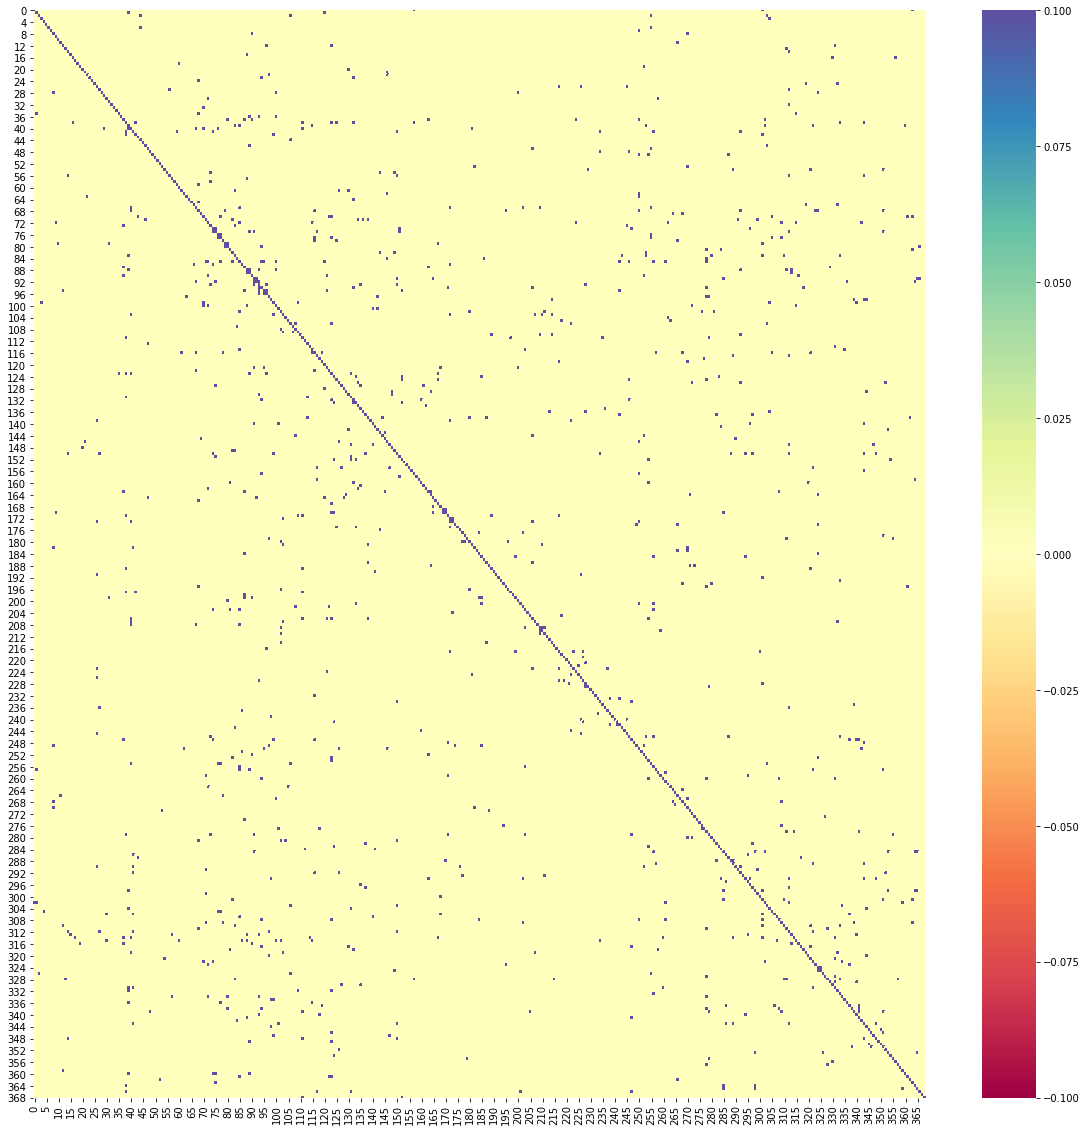

In [79]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs2 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs2, cmap="Spectral", robust=True)

In [80]:
cr2 = classification_report(y_true, y_pred, digits=4)
print(cr2)

              precision    recall  f1-score   support

           0     0.9756    0.8889    0.9302        45
           1     0.7692    0.7692    0.7692        13
           2     0.9412    0.8000    0.8649        20
           3     0.8000    0.8000    0.8000         5
           4     0.9286    1.0000    0.9630        13
           5     1.0000    1.0000    1.0000         7
           6     1.0000    0.9048    0.9500        21
           7     1.0000    0.9444    0.9714        18
           8     0.5116    0.9167    0.6567        24
           9     0.8889    1.0000    0.9412        16
          10     0.9444    1.0000    0.9714        17
          11     0.9167    0.9167    0.9167        12
          12     0.9062    0.9062    0.9062        32
          13     0.9474    0.9000    0.9231        20
          14     0.8000    0.9412    0.8649        17
          15     0.9231    0.8571    0.8889        14
          16     0.9412    0.8421    0.8889        19
          17     0.9167    

## Model with Stratified Train Test Split Dataset

In [ ]:
"""
def stratifiedsplit(df, label_col, input_shape, test_size=0.1, random_seed=0.33):
    lbls_ = list(df[label_col].unique())
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in lbls_:
        # retrieve values for only one label each time
        temp_df = df[df[label_col] == i].copy()
        # shuffle the temp
        temp_df.sample(frac=1).reset_index(drop=True)
        # get x and y from temp_df
        x = np.array(list(temp_df['img']))
        y = np.array(list(temp_df['symbol_id_ohe']))
        x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
        # Normalize data to 0-1
        x = x.astype("float32") / 255.0
        _X_train, _X_test, _y_train, _y_test = train_test_split(x, y, test_size=test_size)
        X_train = X_train + _X_train
        X_test = X_test + _X_test
        y_train = y_train + _y_train
        y_test = y_test + _y_test
    return X_train, X_test, y_train, y_test
"""

In [17]:
def gen_x_y_train_test_stratified(dataset, input_shape, test_size=0.2):
    x = np.array(list(dataset['img']))
    y = np.array(list(dataset['symbol_id_ohe']))
    x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    x = x.astype("float32") / 255.0
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size,  stratify=y)
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = gen_x_y_train_test_stratified(whole_dataset, input_shape, test_size=0.2)

In [22]:
# to count number of records in training set for each label
labels_count = {}
for i in symbols_list:
    labels_count[i] = 0
for i in range(len(y_train)):
    j = one_hot_encode_to_char(y_train[i])[0]
    labels_count[j] += 1
labels_count

{0: 127,
 1: 49,
 2: 107,
 3: 46,
 4: 43,
 5: 45,
 6: 94,
 7: 51,
 8: 80,
 9: 83,
 10: 77,
 11: 89,
 12: 96,
 13: 84,
 14: 67,
 15: 58,
 16: 54,
 17: 66,
 18: 50,
 19: 45,
 20: 47,
 21: 45,
 22: 50,
 23: 43,
 24: 45,
 25: 52,
 26: 853,
 27: 106,
 28: 94,
 29: 99,
 30: 96,
 31: 49,
 32: 62,
 33: 80,
 34: 60,
 35: 97,
 36: 72,
 37: 1226,
 38: 2081,
 39: 905,
 40: 2720,
 41: 898,
 42: 69,
 43: 46,
 44: 54,
 45: 46,
 46: 50,
 47: 53,
 48: 45,
 49: 46,
 50: 47,
 51: 42,
 52: 46,
 53: 45,
 54: 46,
 55: 49,
 56: 50,
 57: 44,
 58: 55,
 59: 49,
 60: 47,
 61: 46,
 62: 50,
 63: 45,
 64: 53,
 65: 46,
 66: 48,
 67: 1528,
 68: 912,
 69: 497,
 70: 997,
 71: 797,
 72: 698,
 73: 549,
 74: 521,
 75: 369,
 76: 435,
 77: 593,
 78: 125,
 79: 201,
 80: 114,
 81: 797,
 82: 353,
 83: 918,
 84: 313,
 85: 2053,
 86: 318,
 87: 639,
 88: 554,
 89: 178,
 90: 339,
 91: 550,
 92: 486,
 93: 1218,
 94: 743,
 95: 450,
 96: 358,
 97: 505,
 98: 658,
 99: 1930,
 100: 2811,
 101: 604,
 102: 843,
 103: 693,
 104: 91,
 105: 

In [23]:
# to count number of records in test set for each label
labels_count = {}
for i in symbols_list:
    labels_count[i] = 0
for i in range(len(y_test)):
    j = one_hot_encode_to_char(y_test[i])[0]
    labels_count[j] += 1
labels_count

{0: 32,
 1: 12,
 2: 27,
 3: 12,
 4: 11,
 5: 11,
 6: 24,
 7: 13,
 8: 20,
 9: 21,
 10: 19,
 11: 22,
 12: 24,
 13: 21,
 14: 17,
 15: 14,
 16: 13,
 17: 17,
 18: 13,
 19: 11,
 20: 12,
 21: 11,
 22: 12,
 23: 11,
 24: 11,
 25: 13,
 26: 213,
 27: 27,
 28: 24,
 29: 25,
 30: 24,
 31: 12,
 32: 16,
 33: 20,
 34: 15,
 35: 24,
 36: 18,
 37: 307,
 38: 520,
 39: 226,
 40: 680,
 41: 225,
 42: 17,
 43: 11,
 44: 13,
 45: 12,
 46: 13,
 47: 13,
 48: 11,
 49: 12,
 50: 12,
 51: 11,
 52: 12,
 53: 11,
 54: 11,
 55: 12,
 56: 12,
 57: 11,
 58: 14,
 59: 12,
 60: 12,
 61: 11,
 62: 13,
 63: 11,
 64: 13,
 65: 12,
 66: 12,
 67: 382,
 68: 228,
 69: 124,
 70: 249,
 71: 199,
 72: 174,
 73: 137,
 74: 130,
 75: 92,
 76: 109,
 77: 148,
 78: 31,
 79: 50,
 80: 29,
 81: 199,
 82: 88,
 83: 229,
 84: 78,
 85: 514,
 86: 80,
 87: 160,
 88: 138,
 89: 44,
 90: 85,
 91: 137,
 92: 121,
 93: 304,
 94: 186,
 95: 112,
 96: 90,
 97: 126,
 98: 165,
 99: 483,
 100: 703,
 101: 151,
 102: 211,
 103: 173,
 104: 23,
 105: 20,
 106: 154,
 107: 

In [42]:
# create network
model = create_network(input_shape, data_format, classes)
# compile network
model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

In [26]:
def gen_x_y_train_test_stratified(_tr, _ts, input_shape):
    # train df
    X_train = np.array(list(_tr['img']))
    y_train = np.array(list(_tr['symbol_id_ohe']))
    X_train = X_train.reshape((X_train.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    X_train = X_train.astype("float32") / 255.0
    # test df
    X_test = np.array(list(_ts['img']))
    y_test = np.array(list(_ts['symbol_id_ohe']))
    X_test = X_test.reshape((X_test.shape[0],1,input_shape[1],input_shape[2]))
    # Normalize data to 0-1
    X_test = X_test.astype("float32") / 255.0
    
    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = gen_x_y_train_test_stratified(train, test, input_shape=input_shape)

In [43]:
epochs = 500
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1)
model.save(model_dir+'hasyv2model31.h5')

Train on 151409 samples, validate on 16824 samples
Epoch 1/500
151409/151409 [==============================] - 29s 189us/step - loss: 5.6494 - acc: 0.0186 - val_loss: 5.4930 - val_acc: 0.0272
Epoch 2/500
151409/151409 [==============================] - 26s 173us/step - loss: 5.4343 - acc: 0.0379 - val_loss: 5.3974 - val_acc: 0.0402
Epoch 3/500
151409/151409 [==============================] - 26s 173us/step - loss: 5.3571 - acc: 0.0533 - val_loss: 5.3336 - val_acc: 0.0545
Epoch 4/500
151409/151409 [==============================] - 26s 174us/step - loss: 5.2795 - acc: 0.0675 - val_loss: 5.2463 - val_acc: 0.0768
Epoch 5/500
151409/151409 [==============================] - 26s 174us/step - loss: 5.1644 - acc: 0.0856 - val_loss: 5.1066 - val_acc: 0.1000
Epoch 6/500
151409/151409 [==============================] - 26s 174us/step - loss: 4.9889 - acc: 0.1137 - val_loss: 4.8985 - val_acc: 0.1400
Epoch 7/500
151409/151409 [==============================] - 26s 174us/step - loss: 4.7438 - acc:

In [44]:
print("Training completed on 02/12")

Training completed on 02/12


### Metrics

In [28]:
# to load model use
model = load_model(model_dir+'hasyv2model31.h5')

In [29]:
res = model.predict(X_test)

In [30]:
# convert predictions from one hot encoded to label value
y_pred = []
for i in range(len(res)):
    # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
    val = one_hot_encode_to_char(res[i], threshold = 0.1, get_max=True)
    if len(val) > 0:
        y_pred.append(val[0])
    else:
        y_pred.append(None)
        print(":(")

In [31]:
# convert test values from one hot encoded to label value
y_true = []
for i in range(len(y_test)):
    # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
    val = one_hot_encode_to_char(y_test[i], threshold = 0.9, get_max=True)
    if len(val) > 0:
        y_true.append(val[0])
    else:
        y_true.append(None)
        print(":(")

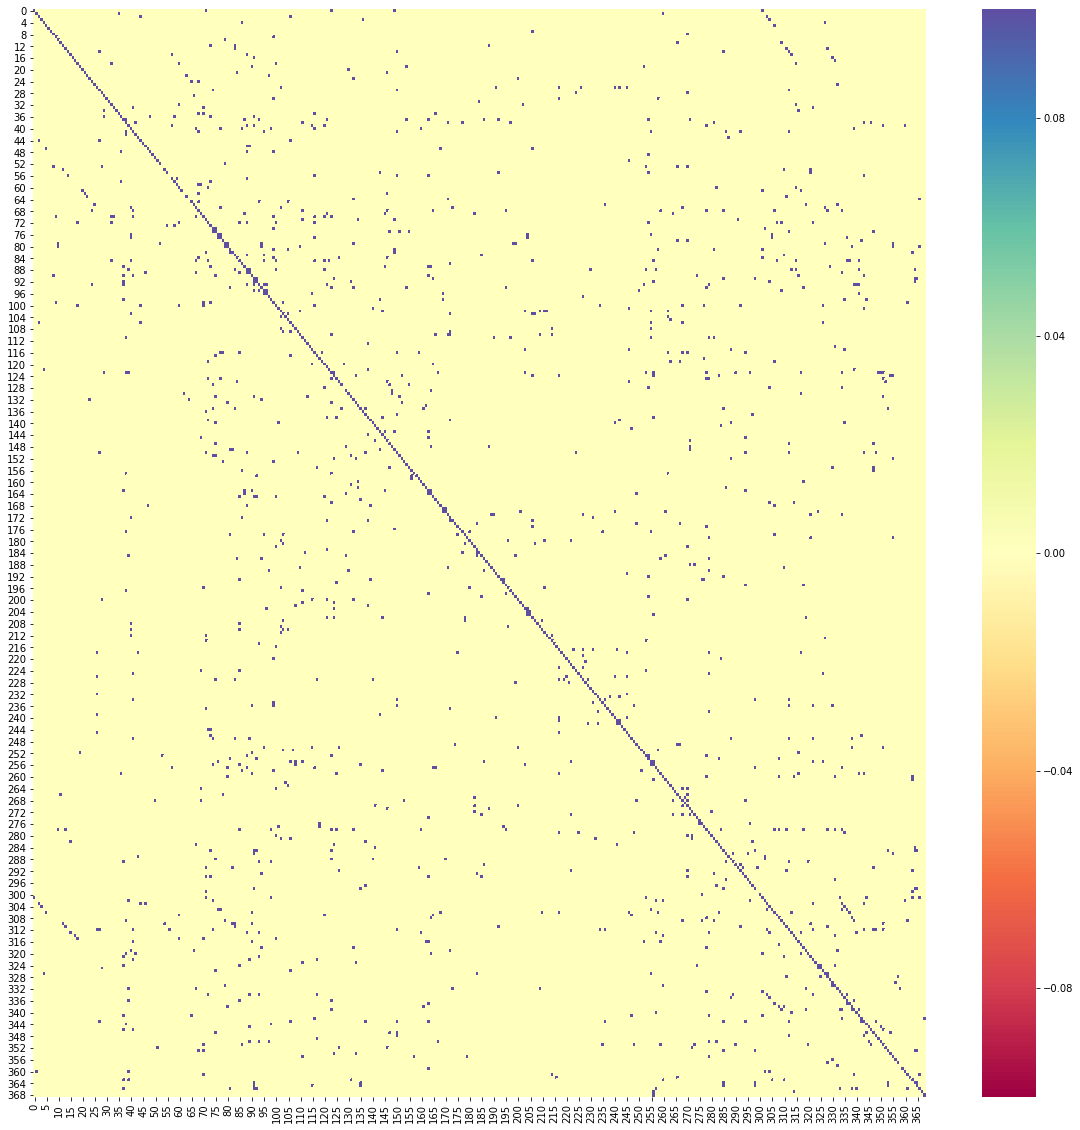

In [32]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs8 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs8, cmap="Spectral", robust=True)

In [33]:
cr8 = classification_report(y_true, y_pred, digits=4)
print(cr8)

              precision    recall  f1-score   support

           0     0.7857    0.6875    0.7333        16
           1     0.8000    0.6667    0.7273         6
           2     0.6667    0.6154    0.6400        13
           3     0.5714    0.6667    0.6154         6
           4     0.6000    0.6000    0.6000         5
           5     0.7143    0.8333    0.7692         6
           6     1.0000    1.0000    1.0000        12
           7     1.0000    0.8333    0.9091         6
           8     0.6667    0.4000    0.5000        10
           9     0.8182    0.9000    0.8571        10
          10     0.7500    0.9000    0.8182        10
          11     0.6154    0.7273    0.6667        11
          12     0.8182    0.7500    0.7826        12
          13     0.6250    0.5000    0.5556        10
          14     0.7500    0.3750    0.5000         8
          15     0.6000    0.4286    0.5000         7
          16     1.0000    0.2857    0.4444         7
          17     0.8750    

### Model with K Fold Cross Validation

In [19]:
x = np.array(list(whole_dataset['img']))
y = np.array(list(whole_dataset['symbol_id_ohe']))
x = x.reshape((x.shape[0],1,input_shape[1],input_shape[2]))
# Normalize data to 0-1
x = x.astype("float32") / 255.0

In [17]:
epochs = 35
kf = KFold(n_splits = 4, shuffle=True)
cnt = 1
for idx_train, idx_test in kf.split(x):
    print("*"*20)
    print(f"K Fold {cnt}")
    X_train, y_train = x[idx_train], y[idx_train]
    X_test, y_test = x[idx_test], y[idx_test]
    # create network
    model = create_network(input_shape, data_format, classes)
    # compile network
    model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])
   
    model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=0)
    model.save(dir_+f"hasyv2model_stratified_kfold{3+cnt}.h5")
    cnt +=1

********************
K Fold 1
Train on 126174 samples, validate on 42059 samples
Epoch 1/35
126174/126174 [==============================] - 36s 284us/step - loss: 4.3652 - acc: 0.1962 - val_loss: 3.1124 - val_acc: 0.3556- loss: 4.3791 - acc: 0
Epoch 2/35
126174/126174 [==============================] - 33s 264us/step - loss: 2.3053 - acc: 0.5037 - val_loss: 1.9603 - val_acc: 0.5575
Epoch 3/35
126174/126174 [==============================] - 33s 263us/step - loss: 1.6145 - acc: 0.6221 - val_loss: 1.5462 - val_acc: 0.6310
Epoch 4/35
126174/126174 [==============================] - 32s 256us/step - loss: 1.2924 - acc: 0.6844 - val_loss: 1.3406 - val_acc: 0.6668
Epoch 5/35
126174/126174 [==============================] - 33s 258us/step - loss: 1.0902 - acc: 0.7242 - val_loss: 1.2128 - val_acc: 0.6941
Epoch 6/35
126174/126174 [==============================] - 33s 264us/step - loss: 0.9470 - acc: 0.7547 - val_loss: 1.1069 - val_acc: 0.7230
Epoch 7/35
126174/126174 [========================

## METRICS

### Draw Confusion Matrix

In [25]:
# to load model use
model = load_model(dir_+'hasyv2model_stratified_kfold7.h5')

In [26]:
res = model.predict(X_test)

In [27]:
# convert predictions from one hot encoded to label value
y_pred = []
for i in range(len(res)):
    # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
    val = one_hot_encode_to_char(res[i], threshold = 0.1, get_max=True)
    if len(val) > 0:
        y_pred.append(val[0])
    else:
        y_pred.append(None)
        print(":(")

In [28]:
# convert test values from one hot encoded to label value
y_true = []
for i in range(len(y_test)):
    # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
    val = one_hot_encode_to_char(y_test[i], threshold = 0.9, get_max=True)
    if len(val) > 0:
        y_true.append(val[0])
    else:
        y_true.append(None)
        print(":(")

In [29]:
cfs4 = confusion_matrix(y_true, y_pred)

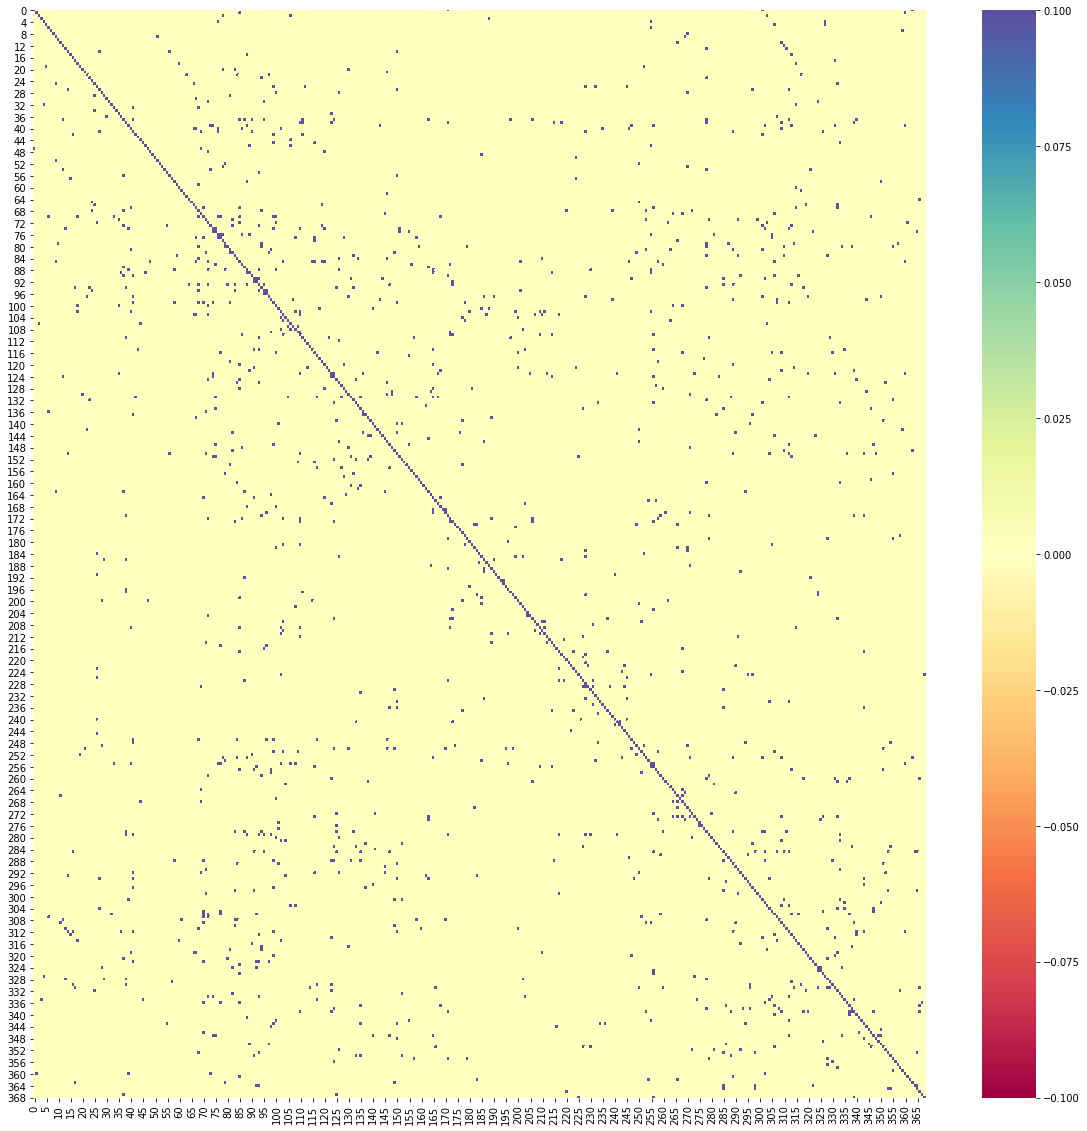

In [30]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
plt.figure(figsize=(20,20))
sn.heatmap(cfs4, cmap="Spectral", robust=True)

### Precision and Recall

In [31]:
cr4 = classification_report(y_true, y_pred, digits=4)
print(cr4)

              precision    recall  f1-score   support

           0     0.9667    0.9062    0.9355        32
           1     0.9000    0.7500    0.8182        12
           2     0.9231    0.8889    0.9057        27
           3     0.9167    0.9167    0.9167        12
           4     0.8000    0.7273    0.7619        11
           5     0.9000    0.8182    0.8571        11
           6     0.8846    0.9583    0.9200        24
           7     1.0000    0.9231    0.9600        13
           8     1.0000    0.8000    0.8889        20
           9     0.8182    0.8571    0.8372        21
          10     0.9500    1.0000    0.9744        19
          11     0.8636    0.8636    0.8636        22
          12     0.8462    0.9167    0.8800        24
          13     0.7391    0.8095    0.7727        21
          14     0.7368    0.8235    0.7778        17
          15     0.8462    0.7857    0.8148        14
          16     0.7647    1.0000    0.8667        13
          17     0.8333    

### T Test

scipy.stats.ttest_ind(y_)

In [34]:
sym2latex = {}
for i in range(len(symbols)):
    sym2latex[symbols.index.values[i]] = symbols.loc[i]['latex']

In [35]:
latex2sym = {v: k for k, v in sym2latex.items()}

In [36]:
def t_test(test_x, test_y, models=[], sym2latex_dict=sym2latex):
    if len(models) < 0:
        raise ValueError("No models found in models variable")
    if len(test_x) != len(test_y):
        raise ValueError("Varibales test_x and test_y are of different length")
    
    # convert test values from one hot encoded to label value
    y_true = []
    for i in range(len(test_y)):
        # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
        val = one_hot_encode_to_char(test_y[i], threshold = 0.9, get_max=True)
        if len(val) > 0:
            y_true.append(val[0])
        else:
            y_true.append(None)
            print(":(")
    no_models = len(models)
    cols = ['symbol','latex']
    preds = []
    # convert predictions from one hot encoded to label value
    for i in range(no_models):
        print("Predictng labels for Model "+str(i))
        cols.append('model'+str(i))
        
        res = models[i].predict(X_test)
        y_pred = []
        for j in range(len(res)):
            # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
            val = one_hot_encode_to_char(res[j], threshold = 0.1, get_max=True)
            if len(val) > 0:
                y_pred.append(val[0])
            else:
                y_pred.append(None)
                print(":(")
        preds.append(y_pred)
    print("Predictions Done")
    print("Comparing Results...")
    # perform t test
    t_test_result = pd.DataFrame(columns=cols)
    for i in range(len(y_true)):
        # value = [y_true[i], sym2latex_dict[y_true[i]]]
        # for j in range(no_models):
        #    value.append(sym2latex_dict[preds[j][i]])
        # t_test_result = t_test_result.append(value)
        t_test_result.loc[i,'symbol'] = y_true[i]
        t_test_result.loc[i,'latex'] = sym2latex_dict[y_true[i]]
        for j in range(no_models):
            t_test_result.loc[i, 'model'+str(j)] = sym2latex_dict[preds[j][i]]
    print("Done")    
    return t_test_result

In [44]:
ms = [
    'hasyv2model.h5',
    'hasyv2model2.h5',
    'hasyv2model3.h5',
    'hasyv2model_stratified_kfold4.h5',
    'hasyv2model_stratified_kfold5.h5',
    'hasyv2model_stratified_kfold6.h5',
    'hasyv2model_stratified_kfold7.h5',
    'hasyv2model21.h5',
    'hasyv2model.h5'
     ]
models = [load_model(model_dir+z) for z in ms]

In [37]:
ms = [model_dir+'hasyv2model.h5']
models = [load_model(model_dir+z) for z in ms]

In [45]:
ttest = t_test(X_test, y_test, models=models)

Predictng labels for Model 0
Predictng labels for Model 1
Predictng labels for Model 2
Predictng labels for Model 3
Predictng labels for Model 4
Predictng labels for Model 5
Predictng labels for Model 6
Predictng labels for Model 7
Predictng labels for Model 8
Predictions Done
Comparing Results...
Done


In [46]:
ttest.head()

,symbol,latex,model0,model1,model2,model3,model4,model5,model6,model7,model8
0,171,\approx,\approx,\approx,\approx,\approx,\approx,\approx,\approx,\approx,\approx
1,68,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma,\gamma
2,67,\Sigma,\Sigma,\Sigma,\sum,\Sigma,\Sigma,\Sigma,\Sigma,\Sigma,\Sigma
3,224,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow,\uparrow
4,72,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta,\zeta


In [47]:
pd.set_option('display.max_rows',None)

In [48]:
def create_t_test_report(test_res):
    models_names = list(test_res.columns.values[2:])
    res = pd.DataFrame(columns=['latex','total_count']+models_names)
    for i in range(len(symbols)):
        res.loc[i,'latex'] = symbols.loc[i,'latex']
        res.loc[i,'total_count'] = 0
        for j in models_names:
            res.loc[i,j] = 0
    for i in range(len(test_res)):
        res.loc[test_res.loc[i,'symbol'],'total_count'] += 1
        for j in models_names:
            if test_res.loc[i,'latex'] == test_res.loc[i,j]:
                res.loc[latex2sym[test_res.loc[i,j]],j] += 1
    for i in range(len(res)):
        for j in models_names:
            res.loc[i,j+'_acc'] = (res.loc[i,j]/res.loc[i,'total_count']) * 100
    return res

In [49]:
t_test_report = create_t_test_report(ttest)
t_test_report.head()

,latex,total_count,model0,model1,model2,model3,model4,model5,model6,model7,model8,model0_acc,model1_acc,model2_acc,model3_acc,model4_acc,model5_acc,model6_acc,model7_acc,model8_acc
0,A,16,16,13,15,15,15,14,15,15,16,100.0,81.250000,93.750000,93.750000,93.750000,87.500000,93.750000,93.750000,100.0
1,B,6,6,4,5,5,4,4,5,4,6,100.0,66.666667,83.333333,83.333333,66.666667,66.666667,83.333333,66.666667,100.0
2,C,13,13,12,12,12,10,12,12,11,13,100.0,92.307692,92.307692,92.307692,76.923077,92.307692,92.307692,84.615385,100.0
3,D,6,6,5,6,2,6,5,6,6,6,100.0,83.333333,100.000000,33.333333,100.000000,83.333333,100.000000,100.000000,100.0
4,E,5,5,4,4,3,4,5,4,5,5,100.0,80.000000,80.000000,60.000000,80.000000,100.000000,80.000000,100.000000,100.0


In [50]:
t_test_report

,latex,total_count,model0,model1,model2,model3,model4,model5,model6,model7,model8,model0_acc,model1_acc,model2_acc,model3_acc,model4_acc,model5_acc,model6_acc,model7_acc,model8_acc
0,A,16,16,13,15,15,15,14,15,15,16,100.000000,81.250000,93.750000,93.750000,93.750000,87.500000,93.750000,93.750000,100.000000
1,B,6,6,4,5,5,4,4,5,4,6,100.000000,66.666667,83.333333,83.333333,66.666667,66.666667,83.333333,66.666667,100.000000
2,C,13,13,12,12,12,10,12,12,11,13,100.000000,92.307692,92.307692,92.307692,76.923077,92.307692,92.307692,84.615385,100.000000
3,D,6,6,5,6,2,6,5,6,6,6,100.000000,83.333333,100.000000,33.333333,100.000000,83.333333,100.000000,100.000000,100.000000
4,E,5,5,4,4,3,4,5,4,5,5,100.000000,80.000000,80.000000,60.000000,80.000000,100.000000,80.000000,100.000000,100.000000
5,F,6,6,6,6,5,5,5,5,6,6,100.000000,100.000000,100.000000,83.333333,83.333333,83.333333,83.333333,100.000000,100.000000
6,G,12,12,11,12,12,12,12,11,10,12,100.000000,91.666667,100.000000,100.000000,100.000000,100.000000,91.666667,83.333333,100.000000
7,H,6,6,4,6,6,4,5,6,6,6,100.000000,66.666667,100.000000,100.000000,66.666667,83.333333,100.000000,100.000000,100.000000
8,I,10,8,8,8,6,7,8,4,8,8,80.000000,80.000000,80.000000,60.000000,70.000000,80.000000,40.000000,80.000000,80.000000
9,J,10,10,9,10,10,8,10,10,10,10,100.000000,90.000000,100.000000,100.000000,80.000000,100.000000,100.000000,100.000000,100.000000
